In [1]:
import dgl

Using backend: pytorch


In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
import dgl

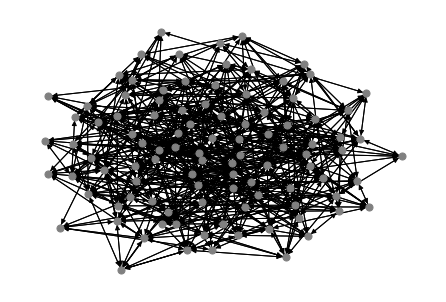

In [3]:
N = 100  # number of nodes
DAMP = 0.85  # damping factor
K = 10  # number of iterations
g = nx.nx.erdos_renyi_graph(N, 0.1)
g = dgl.DGLGraph(g)
nx.draw(g.to_networkx(), node_size=50, node_color=[[.5, .5, .5,]])
plt.show()

In [4]:
g.ndata['pv'] = torch.ones(N) / N
g.ndata['deg'] = g.out_degrees(g.nodes()).float()

In [5]:
import torch as th

x = th.randn(10, 3)

In [6]:
x

tensor([[ 0.4838,  0.2368, -0.8245],
        [ 0.0614,  1.3604, -0.6352],
        [-0.9240,  0.6594, -1.0648],
        [ 0.8098,  0.3313,  0.2942],
        [ 0.1039, -2.9744,  0.1005],
        [-0.4610,  1.4947,  1.6074],
        [-2.3974, -1.1959, -1.0977],
        [-1.3737, -0.5540,  0.8457],
        [ 0.3661, -1.8211,  0.2022],
        [ 0.7576,  0.6163,  0.5287]])

In [7]:
def pagerank_message_func(edges):
    return {'pv' : edges.src['pv'] / edges.src['deg']}

In [8]:
def pagerank_reduce_func(nodes):
    msgs = torch.sum(nodes.mailbox['pv'], dim=1)
    pv = (1 - DAMP) / N + DAMP * msgs
    return {'pv' : pv}

In [14]:
g.register_message_func(pagerank_message_func)
g.register_reduce_func(pagerank_reduce_func)

In [9]:
def pagerank_naive(g):
    # Phase #1: send out messages along all edges.
    for u, v in zip(*g.edges()):
        g.send((u, v))
    # Phase #2: receive messages to compute new PageRank values.
    for v in g.nodes():
        g.recv(v)

In [10]:
def pagerank_batch(g):
    g.send(g.edges())
    g.recv(g.nodes())

In [11]:
def pagerank_level2(g):
    g.update_all()

In [12]:
import dgl.function as fn

def pagerank_builtin(g):
    g.ndata['pv'] = g.ndata['pv'] / g.ndata['deg']
    g.update_all(message_func=fn.copy_src(src='pv', out='m'),
                 reduce_func=fn.sum(msg='m',out='m_sum'))
    g.ndata['pv'] = (1 - DAMP) / N + DAMP * g.ndata['m_sum']

In [14]:
for k in range(K):
    # Uncomment the corresponding line to select different version.
     pagerank_naive(g)
     #pagerank_batch(g)
    # pagerank_level2(g)
    #pagerank_builtin(g)
print(g.ndata['pv'])

..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


tensor([0.0148, 0.0080, 0.0096, 0.0123, 0.0080, 0.0079, 0.0063, 0.0138, 0.0088,
        0.0065, 0.0073, 0.0123, 0.0104, 0.0081, 0.0079, 0.0074, 0.0155, 0.0122,
        0.0106, 0.0122, 0.0148, 0.0080, 0.0073, 0.0089, 0.0138, 0.0072, 0.0122,
        0.0098, 0.0090, 0.0080, 0.0099, 0.0084, 0.0121, 0.0107, 0.0121, 0.0114,
        0.0096, 0.0089, 0.0072, 0.0098, 0.0162, 0.0072, 0.0072, 0.0079, 0.0089,
        0.0155, 0.0075, 0.0145, 0.0074, 0.0114, 0.0083, 0.0088, 0.0106, 0.0122,
        0.0120, 0.0130, 0.0106, 0.0115, 0.0056, 0.0064, 0.0081, 0.0147, 0.0090,
        0.0129, 0.0122, 0.0098, 0.0121, 0.0098, 0.0102, 0.0057, 0.0089, 0.0104,
        0.0131, 0.0049, 0.0142, 0.0114, 0.0091, 0.0073, 0.0114, 0.0083, 0.0115,
        0.0115, 0.0064, 0.0095, 0.0066, 0.0082, 0.0108, 0.0063, 0.0082, 0.0120,
        0.0137, 0.0137, 0.0089, 0.0089, 0.0092, 0.0090, 0.0090, 0.0115, 0.0098,
        0.0096])


In [15]:
for k in range(K):
    # Uncomment the corresponding line to select different version.
     #pagerank_naive(g)
    #pagerank_batch(g)
    pagerank_level2(g)
    #pagerank_builtin(g)
print(g.ndata['pv'])

tensor([0.0122, 0.0140, 0.0113, 0.0116, 0.0096, 0.0130, 0.0090, 0.0073, 0.0129,
        0.0090, 0.0112, 0.0066, 0.0088, 0.0095, 0.0147, 0.0123, 0.0139, 0.0090,
        0.0064, 0.0114, 0.0107, 0.0123, 0.0073, 0.0138, 0.0079, 0.0080, 0.0106,
        0.0047, 0.0072, 0.0072, 0.0139, 0.0107, 0.0118, 0.0116, 0.0073, 0.0114,
        0.0089, 0.0080, 0.0071, 0.0106, 0.0081, 0.0107, 0.0121, 0.0072, 0.0064,
        0.0095, 0.0106, 0.0130, 0.0107, 0.0154, 0.0072, 0.0137, 0.0058, 0.0112,
        0.0064, 0.0089, 0.0106, 0.0088, 0.0086, 0.0105, 0.0129, 0.0137, 0.0097,
        0.0115, 0.0081, 0.0106, 0.0089, 0.0130, 0.0072, 0.0063, 0.0107, 0.0058,
        0.0072, 0.0082, 0.0105, 0.0155, 0.0088, 0.0104, 0.0111, 0.0063, 0.0130,
        0.0121, 0.0039, 0.0056, 0.0081, 0.0081, 0.0142, 0.0056, 0.0140, 0.0097,
        0.0090, 0.0089, 0.0106, 0.0122, 0.0120, 0.0154, 0.0097, 0.0137, 0.0113,
        0.0064])
